In [249]:
!pip install geopy


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [250]:
from dbfread import DBF
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, \
    RandomForestClassifier, RandomForestRegressor,  ExtraTreesRegressor, \
    BaggingRegressor,  GradientBoostingRegressor, \
    AdaBoostRegressor,  VotingRegressor, StackingRegressor, \
    HistGradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import datetime

from sklearn.neighbors import NearestNeighbors

import os
import ee
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
import csv
import datetime
from tqdm import tqdm
from geopy.distance import geodesic 


# DONNÉES BRUTES

In [251]:
from pyproj import Transformer

data = pd.read_csv('../data/use/ird/Data_to_Analyze.csv')
landsat_ird_data_8 = pd.read_csv('lansat_ird_results_landsat8.csv')
landsat_ird_data_7 = pd.read_csv('lansat_ird_results_landsat7.csv')
landsat_ird_data_8_2 = pd.read_csv('lansat_ird_results_landsat8_3.csv')
bary = pd.read_csv('../data/use/ird/Données/Bary.csv')
sop = pd.read_csv('../data/use/ird/Données/Sop.csv')
diohene = pd.read_csv('../data/use/ird/Données/Diohene.csv')




data.dropna(inplace=True, axis=0, how='any')
data.info()

# Exemple de point de référence
ref_point = (14.5, -16.9)  # (latitude, longitude)

# Définir le transformateur pour convertir les coordonnées projetées en latitude/longitude
# Remplacez '32628' par le code EPSG correct de votre projection si besoin
transformer = Transformer.from_crs("EPSG:32628", "EPSG:4326", always_xy=True)

def get_latlon(row):
    lon, lat = transformer.transform(row['X_Centroid'], row['Y_Centroid'])
    return lat, lon

# Calculer la distance géodésique
data['distance'] = data.apply(
    lambda row: geodesic(get_latlon(row), ref_point).kilometers,
    axis=1
)
data

<class 'pandas.core.frame.DataFrame'>
Index: 3498 entries, 0 to 3625
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Profile_id  3498 non-null   int64  
 1   X_Centroid  3498 non-null   float64
 2   Y_Centroid  3498 non-null   float64
 3   Carbon      3498 non-null   float64
 4   Epaisseur   3498 non-null   float64
 5   Profondeur  3498 non-null   float64
 6   B_1         3498 non-null   float64
 7   B_2         3498 non-null   float64
 8   B_3         3498 non-null   float64
 9   B_4         3498 non-null   float64
 10  B_5         3498 non-null   float64
 11  B_6         3498 non-null   float64
 12  B_7         3498 non-null   float64
 13  B_8         3498 non-null   float64
 14  B_8A        3498 non-null   float64
 15  B_9         3498 non-null   float64
 16  B_10        3498 non-null   float64
 17  B_11        3498 non-null   float64
 18  B_12        3498 non-null   float64
 19  MNT_1       3498 non-null   floa

,Profile_id,X_Centroid,Y_Centroid,Carbon,Epaisseur,Profondeur,B_1,B_2,B_3,B_4,...,B_12,MNT_1,geometry,NDVI,GDVI,MSAVI2,PSRINIR,NDWI,CIGreen,distance
0,1550,337391.020695,1.603426e+06,4.18,10.0,10.0,0.17855,0.17550,0.19990,0.26885,...,0.41065,12.962011,POINT (337391.020695 1603426.161072),0.099782,0.243305,0.075370,1.202013,-0.243305,0.147093,42.156743
1,1551,337391.020695,1.603426e+06,4.13,20.0,30.0,0.17855,0.17550,0.19990,0.26885,...,0.41065,12.962011,POINT (337391.020695 1603426.161072),0.099782,0.243305,0.075370,1.202013,-0.243305,0.147093,42.156743
2,1552,336914.113937,1.603585e+06,5.26,10.0,10.0,0.18155,0.17585,0.20025,0.27165,...,0.42455,15.547010,POINT (336914.113937 1603584.630185),0.101092,0.248593,0.076924,1.173721,-0.248593,0.151303,41.678423
3,1553,336914.113937,1.603585e+06,9.16,20.0,30.0,0.18155,0.17585,0.20025,0.27165,...,0.42455,15.547010,POINT (336914.113937 1603584.630185),0.101092,0.248593,0.076924,1.173721,-0.248593,0.151303,41.678423
10,1560,334835.800902,1.603042e+06,3.90,10.0,10.0,0.18640,0.18565,0.21390,0.28820,...,0.47530,13.255346,POINT (334835.800902 1603041.881657),0.091926,0.236685,0.071988,1.166050,-0.236685,0.147978,39.607726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621,2641,338225.669600,1.613196e+06,8.24,20.0,30.0,0.16600,0.16980,0.19530,0.25750,...,0.32470,18.997011,POINT (338225.6696 1613195.766),0.164910,0.295582,0.127883,1.424831,-0.295582,0.137367,43.987817
3622,2642,338432.545800,1.612860e+06,4.88,10.0,10.0,0.16560,0.15580,0.17480,0.20700,...,0.29490,21.105345,POINT (338432.5458 1612860.281),0.195492,0.275290,0.136021,1.424734,-0.275290,0.084337,44.120495
3623,2643,338432.545800,1.612860e+06,7.56,20.0,30.0,0.16560,0.15580,0.17480,0.20700,...,0.29490,21.105345,POINT (338432.5458 1612860.281),0.195492,0.275290,0.136021,1.424734,-0.275290,0.084337,44.120495
3624,2644,338485.918100,1.612929e+06,6.71,10.0,10.0,0.16130,0.15570,0.17380,0.22290,...,0.29930,19.088678,POINT (338485.9181 1612929.277),0.225100,0.339415,0.168598,1.639070,-0.339415,0.123771,44.186840


In [252]:
""" # columns_to_ignore = ['Unnamed: 0', 'Propriétaire', '2013', '2012', '2011_1', '2010', 'Typsol', 'Nom_champs', 'Code', 'yyyyy', 'Nombre_et', 'Numero_cha', 'Num_Conc', 'Num_Men', 'Num_Parc', 'Concessi_1', 'Superficie (m²)', 'Equivalenc', 'AREA (m²)', 'PERIMETER', 'Ref_SN', 'StockC_0-30 (Mg ha)', 'Num_Parcel', 'Mes numéros de parcelles', 'Num_Foyer_', 'Nom_Propri', 'Prenom_Pro', 'Num_Foye_1', 'Nom_Utilis', 'Prenom_Uti', 'Nom_Champ', 'Nbre_Semoi', 'Surface_Es', 'Surface_Ca', 'Denominati', '2015_Occup', '2014_Occup', '2013_Occup', '2012_Occup', 'Age_Jacher', 'Raison1_Ja', 'Type_de_so', 'OccupLand2', 'StockC_0-30cm (Mg ha)', 'N°_PARCELL', 'N°_FOYER', 'SAISON', 'NOM_UTILIS', 'NOM_PROPRI', 'UTL_2012', 'NOM_CHAMPS', 'NOMBR_ARBR', 'TYP_SOL', 'SUPERFICIE', 'Categorie_', 'Réf SN']
columns_to_ignore = ['Unnamed: 0', 'Propriétaire', '2013', '2012', '2011_1', '2010', 'Typsol', 'Nom_champs', 'Code', 'yyyyy', 'Nombre_et', 'Numero_cha', 'Num_Conc', 'Num_Men', 'Num_Parc', 'Concessi_1', 'Superficie (m²)', 'Equivalenc', 'AREA (m²)', 'PERIMETER', 'Ref_SN', 'StockC_0-30 (Mg ha)', 'Num_Parcel', 'Mes numéros de parcelles', 'Num_Foyer_', 'Nom_Propri', 'Prenom_Pro', 'Num_Foye_1', 'Nom_Utilis', 'Prenom_Uti', 'Nom_Champ', 'Nbre_Semoi', 'Surface_Es', 'Surface_Ca', 'Denominati', '2015_Occup', '2014_Occup', '2013_Occup', '2012_Occup', 'Age_Jacher', 'Raison1_Ja', 'Type_de_so', 'OccupLand2', 'StockC_0-30cm (Mg ha)', 'N°_PARCELL', 'N°_FOYER', 'SAISON', 'NOM_UTILIS', 'NOM_PROPRI', 'UTL_2012', 'NOM_CHAMPS', 'NOMBR_ARBR', 'TYP_SOL', 'SUPERFICIE', 'Categorie_', 'Réf SN']
all = pd.concat([bary, sop, diohene], ignore_index=True)
colums_in_all ,columns_not_in_all = [], []  
for col in all.columns:
    if col in bary.columns and col in sop.columns and col in diohene.columns:
        colums_in_all.append(col)
    else:
        columns_not_in_all.append(col)
        
print("Columns in all datasets:", colums_in_all)
print("Columns not in all datasets:", columns_not_in_all)
new_all = all.drop(columns=columns_not_in_all)
new_all['profile_id'] = f"{new_all['X_Centroid']}_{new_all['Y_Centroid']}"
# save the new dataframe to a CSV file
new_all.to_csv('../data/use/ird/all_profiles.csv', index=False)
 """

map_longitude_latitude_profile_id_df = pd.read_csv('../data/use/ird/map_longitude_latitude_profile_id.csv')
all =pd.read_csv('../data/use/ird/all_profiles.csv')



tr = Transformer.from_crs(32628, 4326, always_xy=True)

all[["Longitude", "Latitude"]] = all.apply(
    lambda r: tr.transform(r["X_Centroid"], r["Y_Centroid"]),
    axis=1, result_type="expand"
)
all['Longitude_Latitude'] = all.apply(lambda row: f"({row['Longitude']}, {row['Latitude']})", axis=1)
# map_longitude_latitude_profile_id_df
all = pd.merge(all, map_longitude_latitude_profile_id_df, on='Longitude_Latitude', how='left')
all

,X_Centroid,Y_Centroid,[SOC] (g/kg),Stock_C (Mg ha),Profondeur(cm),Depth,Num_Parc_1,Type_sol,Sand (%),Predicted_FF (%),...,Couverture_sol,Antécédent_cultural,Termitère,Date,Saison,profile_id,Longitude,Latitude,Longitude_Latitude,ProfileID
0,337666.904000,1.613466e+06,"7,29",11.08,10,Surface,685,Dior,"88,1","6,8",...,2,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506981,14.589541,"(-16.50698122059441, 14.589540770954374)",IRD_1
1,337666.904000,1.613466e+06,"1,61",4.93,30,Profondeur,685,Dior,"88,5","3,4",...,2,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506981,14.589541,"(-16.50698122059441, 14.589540770954374)",IRD_1
2,337665.277100,1.613491e+06,"12,36",19.28,10,Surface,345,Dior,"85,3","7,4",...,0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506998,14.589767,"(-16.506997857480123, 14.589766642649971)",IRD_2
3,337665.277100,1.613491e+06,"2,88",8.98,30,Profondeur,345,Dior,"91,1","1,9",...,0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506998,14.589767,"(-16.506997857480123, 14.589766642649971)",IRD_2
4,337901.175800,1.613567e+06,"3,67",5.62,10,Surface,25,DeckMbel,"91,5","3,2",...,0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.504813,14.590472,"(-16.50481317850653, 14.590471649283188)",IRD_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621,336184.773989,1.602435e+06,"2,07","6,31",30,Profondeur,55,Dior,"83,3","6,9",...,0,2.0,0.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.520055,14.489747,"(-16.52005474132454, 14.489747054436316)",IRD_1798
3622,336295.437751,1.602552e+06,"2,27","3,57",10,Surface,56,Dior,"91,1","2,5",...,0,2.0,1.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.519035,14.490810,"(-16.519035333984363, 14.490809959571386)",IRD_1799
3623,336295.437751,1.602552e+06,"2,14","6,49",30,Profondeur,56,Dior,"89,1","3,3",...,0,2.0,1.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.519035,14.490810,"(-16.519035333984363, 14.490809959571386)",IRD_1799
3624,337724.804001,1.603323e+06,"5,46","8,30",10,Surface,49,Dior,"88,7","6,0",...,1,2.0,0.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.505822,14.497869,"(-16.505822431326113, 14.497868606991085)",IRD_1800


In [253]:
# print unique values in 'Type_sol' column
print(all['Type_sol'].unique())
print(all['Type_champ'].unique())
print(all['Site'].unique())
print(all['Depth'].unique())
print(all['Parcage'].unique())
# all = pd.get_dummies(all, columns=['Type_sol', 'Type_champ', 'Site'], drop_first=True)

all['Type_sol'] = all['Type_sol'].astype('category').cat.codes
all['Type_champ'] = all['Type_champ'].astype('category').cat.codes
all['Site'] = all['Site'].astype('category').cat.codes

# all['Depth'] = all['Depth'].astype('category').cat.codes
# all['Parcage'] = all['Parcage'].astype('category').cat.codes
all

['Dior' 'DeckMbel' 'DeckDior' 'Deck']
['CC' 'CB']
['Bari' 'Sob' 'Diohine']
['Surface' 'Profondeur']
['0' '1' '_']


,X_Centroid,Y_Centroid,[SOC] (g/kg),Stock_C (Mg ha),Profondeur(cm),Depth,Num_Parc_1,Type_sol,Sand (%),Predicted_FF (%),...,Couverture_sol,Antécédent_cultural,Termitère,Date,Saison,profile_id,Longitude,Latitude,Longitude_Latitude,ProfileID
0,337666.904000,1.613466e+06,"7,29",11.08,10,Surface,685,3,"88,1","6,8",...,2,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506981,14.589541,"(-16.50698122059441, 14.589540770954374)",IRD_1
1,337666.904000,1.613466e+06,"1,61",4.93,30,Profondeur,685,3,"88,5","3,4",...,2,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506981,14.589541,"(-16.50698122059441, 14.589540770954374)",IRD_1
2,337665.277100,1.613491e+06,"12,36",19.28,10,Surface,345,3,"85,3","7,4",...,0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506998,14.589767,"(-16.506997857480123, 14.589766642649971)",IRD_2
3,337665.277100,1.613491e+06,"2,88",8.98,30,Profondeur,345,3,"91,1","1,9",...,0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506998,14.589767,"(-16.506997857480123, 14.589766642649971)",IRD_2
4,337901.175800,1.613567e+06,"3,67",5.62,10,Surface,25,2,"91,5","3,2",...,0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.504813,14.590472,"(-16.50481317850653, 14.590471649283188)",IRD_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621,336184.773989,1.602435e+06,"2,07","6,31",30,Profondeur,55,3,"83,3","6,9",...,0,2.0,0.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.520055,14.489747,"(-16.52005474132454, 14.489747054436316)",IRD_1798
3622,336295.437751,1.602552e+06,"2,27","3,57",10,Surface,56,3,"91,1","2,5",...,0,2.0,1.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.519035,14.490810,"(-16.519035333984363, 14.490809959571386)",IRD_1799
3623,336295.437751,1.602552e+06,"2,14","6,49",30,Profondeur,56,3,"89,1","3,3",...,0,2.0,1.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.519035,14.490810,"(-16.519035333984363, 14.490809959571386)",IRD_1799
3624,337724.804001,1.603323e+06,"5,46","8,30",10,Surface,49,3,"88,7","6,0",...,1,2.0,0.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.505822,14.497869,"(-16.505822431326113, 14.497868606991085)",IRD_1800


In [254]:
# print types of columns
# print(all.dtypes)



to_float = [ '[SOC] (g/kg)', 'Stock_C (Mg ha)', 'Profondeur(cm)', 'Depth', 'Num_Parc_1', 'Type_sol', 'Sand (%)', 'Predicted_FF (%)', 'FF_0-30', 'Type_champ', 'Site', 'Epaisseur_(cm)', 'Superficie_(ha)', 'Da_(g/cm3)', 'Parcage', 'Couverture_sol', 'Antécédent_cultural', 'Termitère']
stri_cols = [] # ['Depth',  'Site', 'Parcage', ]
# Convert specified columns to float
for col in to_float:
    all[col] = all[col].astype(str)
    if col not in stri_cols:
        # replace commas with dots and convert to numeric
        all[col] = all[col].str.replace(',', '.')
        
        all[col] = pd.to_numeric(all[col], errors='coerce')
print(all.dtypes)
all

X_Centroid             float64
Y_Centroid             float64
[SOC] (g/kg)           float64
Stock_C (Mg ha)        float64
Profondeur(cm)           int64
Depth                  float64
Num_Parc_1             float64
Type_sol                 int64
Sand (%)               float64
Predicted_FF (%)       float64
FF_0-30                float64
Type_champ               int64
Site                     int64
Epaisseur_(cm)           int64
Superficie_(ha)        float64
Da_(g/cm3)             float64
Parcage                float64
Couverture_sol         float64
Antécédent_cultural    float64
Termitère              float64
Date                    object
Saison                  object
profile_id              object
Longitude              float64
Latitude               float64
Longitude_Latitude      object
ProfileID               object
dtype: object


,X_Centroid,Y_Centroid,[SOC] (g/kg),Stock_C (Mg ha),Profondeur(cm),Depth,Num_Parc_1,Type_sol,Sand (%),Predicted_FF (%),...,Couverture_sol,Antécédent_cultural,Termitère,Date,Saison,profile_id,Longitude,Latitude,Longitude_Latitude,ProfileID
0,337666.904000,1.613466e+06,7.29,11.08,10,NaN,685.0,3,88.1,6.8,...,2.0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506981,14.589541,"(-16.50698122059441, 14.589540770954374)",IRD_1
1,337666.904000,1.613466e+06,1.61,4.93,30,NaN,685.0,3,88.5,3.4,...,2.0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506981,14.589541,"(-16.50698122059441, 14.589540770954374)",IRD_1
2,337665.277100,1.613491e+06,12.36,19.28,10,NaN,345.0,3,85.3,7.4,...,0.0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506998,14.589767,"(-16.506997857480123, 14.589766642649971)",IRD_2
3,337665.277100,1.613491e+06,2.88,8.98,30,NaN,345.0,3,91.1,1.9,...,0.0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.506998,14.589767,"(-16.506997857480123, 14.589766642649971)",IRD_2
4,337901.175800,1.613567e+06,3.67,5.62,10,NaN,25.0,2,91.5,3.2,...,0.0,2.0,0.0,21/7/2016,SS,0 337666.904000\n1 337666.904000\n...,-16.504813,14.590472,"(-16.50481317850653, 14.590471649283188)",IRD_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621,336184.773989,1.602435e+06,2.07,6.31,30,NaN,55.0,3,83.3,6.9,...,0.0,2.0,0.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.520055,14.489747,"(-16.52005474132454, 14.489747054436316)",IRD_1798
3622,336295.437751,1.602552e+06,2.27,3.57,10,NaN,56.0,3,91.1,2.5,...,0.0,2.0,1.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.519035,14.490810,"(-16.519035333984363, 14.490809959571386)",IRD_1799
3623,336295.437751,1.602552e+06,2.14,6.49,30,NaN,56.0,3,89.1,3.3,...,0.0,2.0,1.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.519035,14.490810,"(-16.519035333984363, 14.490809959571386)",IRD_1799
3624,337724.804001,1.603323e+06,5.46,8.30,10,NaN,49.0,3,88.7,6.0,...,1.0,2.0,0.0,26/8/2016,SH,0 337666.904000\n1 337666.904000\n...,-16.505822,14.497869,"(-16.505822431326113, 14.497868606991085)",IRD_1800


In [255]:
landsat_ird_data_8_2

,ProfileID,Longitude,Latitude,T_Year,Start_Date,End_Date,Satellite,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,QA_PIXEL
0,IRD_8,-16.502787,14.590484,2016,2016-01-01,2016-12-31,Landsat-8,10503.423077,11264.480276,13692.774162,16551.284024,21070.683432,28060.604536,25739.922091,21824.0
1,IRD_7,-16.502643,14.588947,2016,2016-01-01,2016-12-31,Landsat-8,10322.370553,11187.454545,13609.738142,16178.544466,21005.475296,27521.168972,24983.906126,21824.0
2,IRD_3,-16.504813,14.590472,2016,2016-01-01,2016-12-31,Landsat-8,10402.215976,11294.015779,13830.328402,16600.637081,21326.907298,28143.011834,25794.826430,21824.0
3,IRD_5,-16.504733,14.589508,2016,2016-01-01,2016-12-31,Landsat-8,10095.584403,10882.888450,13032.569595,15320.353406,20030.712734,25631.906219,23030.277394,21824.0
4,IRD_4,-16.504652,14.589834,2016,2016-01-01,2016-12-31,Landsat-8,10219.085714,11103.708374,13517.827586,16227.502463,21110.740887,27282.456158,24554.470936,21824.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,IRD_1796,-16.506139,14.489478,2016,2016-01-01,2016-12-31,Landsat-8,10377.359329,11302.049358,13791.476802,16552.448174,21299.229023,27955.166831,24787.390918,21824.0
1796,IRD_1794,-16.506308,14.490141,2016,2016-01-01,2016-12-31,Landsat-8,10386.010848,11340.312623,13881.697239,16696.323471,21527.393491,27923.627219,24562.217949,21824.0
1797,IRD_1798,-16.520055,14.489747,2016,2016-01-01,2016-12-31,Landsat-8,11148.366864,12083.822485,14947.796844,18124.431953,22709.339250,29384.819527,26545.734714,21824.0
1798,IRD_1799,-16.519035,14.490810,2016,2016-01-01,2016-12-31,Landsat-8,11039.044335,11947.956650,14757.445320,17943.737931,22896.266995,28867.213793,25181.205911,21824.0


In [256]:
data7
# show the description of the dataframe nan

df_train_7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1808 entries, 0 to 3624
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X_Centroid           1808 non-null   float64
 1   Y_Centroid           1808 non-null   float64
 2   [SOC] (g/kg)         1808 non-null   float64
 3   Stock_C (Mg ha)      1808 non-null   float64
 4   Profondeur(cm)       1808 non-null   int64  
 5   Depth                0 non-null      float64
 6   Num_Parc_1           1175 non-null   float64
 7   Type_sol             1808 non-null   int64  
 8   Sand (%)             1808 non-null   float64
 9   Predicted_FF (%)     1808 non-null   float64
 10  FF_0-30              26 non-null     float64
 11  Type_champ           1808 non-null   int64  
 12  Site                 1808 non-null   int64  
 13  Epaisseur_(cm)       1808 non-null   int64  
 14  Superficie_(ha)      1808 non-null   float64
 15  Da_(g/cm3)           1808 non-null   float6

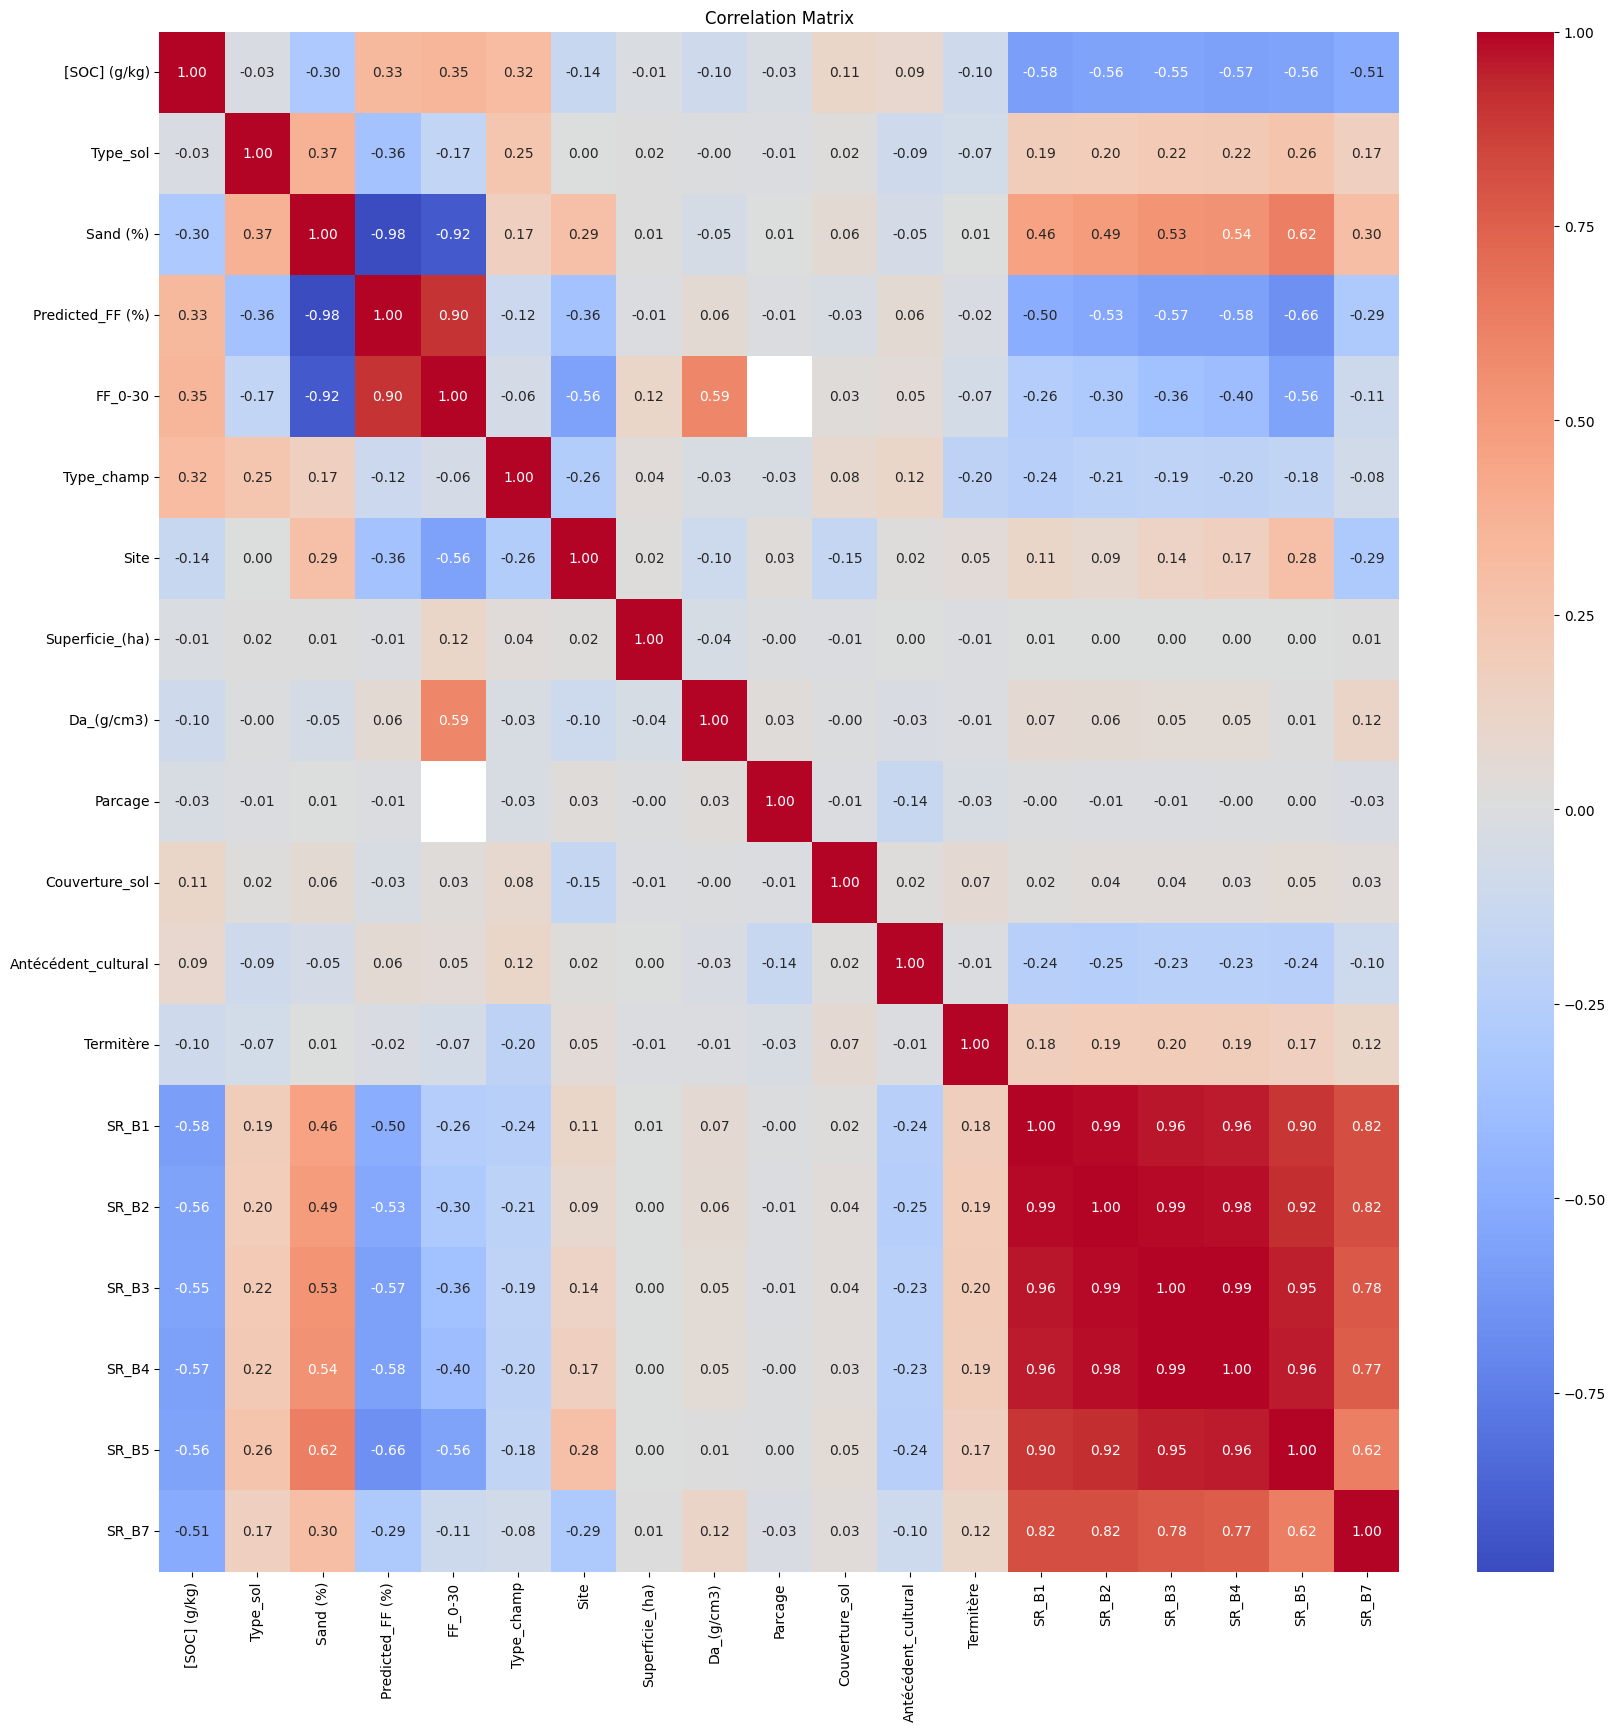

/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-p

Comparaison des modèles :

Linear Regression :
  Mean Squared Error: 1.37
  R² Score: 0.46
----------------------------------------
Random Forest :
  Mean Squared Error: 1.41
  R² Score: 0.45
----------------------------------------
GradientBoostingRegressor :
  Mean Squared Error: 1.33
  R² Score: 0.48
----------------------------------------
ExtraTreesRegressor :
  Mean Squared Error: 1.54
  R² Score: 0.39
----------------------------------------
BaggingRegressor :
  Mean Squared Error: 1.44
  R² Score: 0.43
----------------------------------------
VotingRegressor :
  Mean Squared Error: 1.39
  R² Score: 0.46
----------------------------------------
StackingRegressor :
  Mean Squared Error: 1.40
  R² Score: 0.45
----------------------------------------
HistGradientBoostingRegressor :
  Mean Squared Error: 1.54
  R² Score: 0.40
----------------------------------------


In [260]:
data7 = pd.merge(all, landsat_ird_data_8_2, on='ProfileID', how='left')
data7 = data7[data7['Profondeur(cm)']==10.0].copy()
corr_matrix = data7[['[SOC] (g/kg)', 'Type_sol', 'Sand (%)', 'Predicted_FF (%)', 'FF_0-30', 'Type_champ', 'Site', 'Superficie_(ha)', 'Da_(g/cm3)', 'Parcage', 'Couverture_sol', 'Antécédent_cultural', 'Termitère','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
df_train_7 = replace_outliers_with_quantile(df_train_7, '[SOC] (g/kg)',)
df_train_7 = data7.copy()
df_train_7 = data7.dropna(subset=['[SOC] (g/kg)', 'Sand (%)', 'Predicted_FF (%)', 'Type_champ', 'Site', 'Superficie_(ha)', 'Da_(g/cm3)', 'Parcage', 'Couverture_sol', 'Antécédent_cultural', 'Termitère','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7'])
X_train_7 = df_train_7[[ 'SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']]
Y_train_7 = df_train_7['[SOC] (g/kg)']
train(X_train_7, Y_train_7)




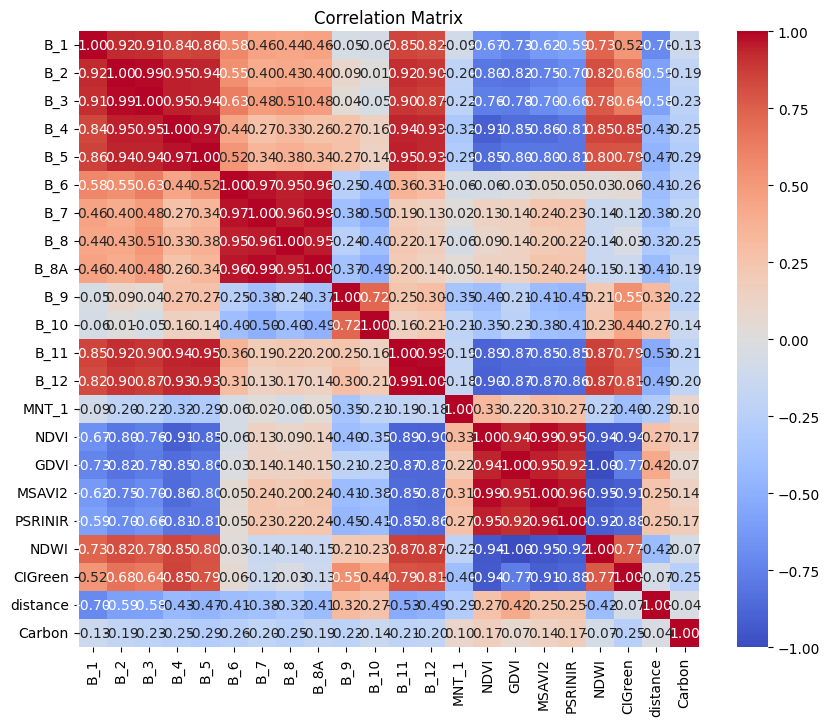

In [68]:
corr_matrix = data[['B_1','B_2','B_3','B_4','B_5','B_6','B_7','B_8','B_8A','B_9','B_10','B_11','B_12','MNT_1','NDVI','GDVI','MSAVI2','PSRINIR','NDWI','CIGreen','distance','Carbon']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

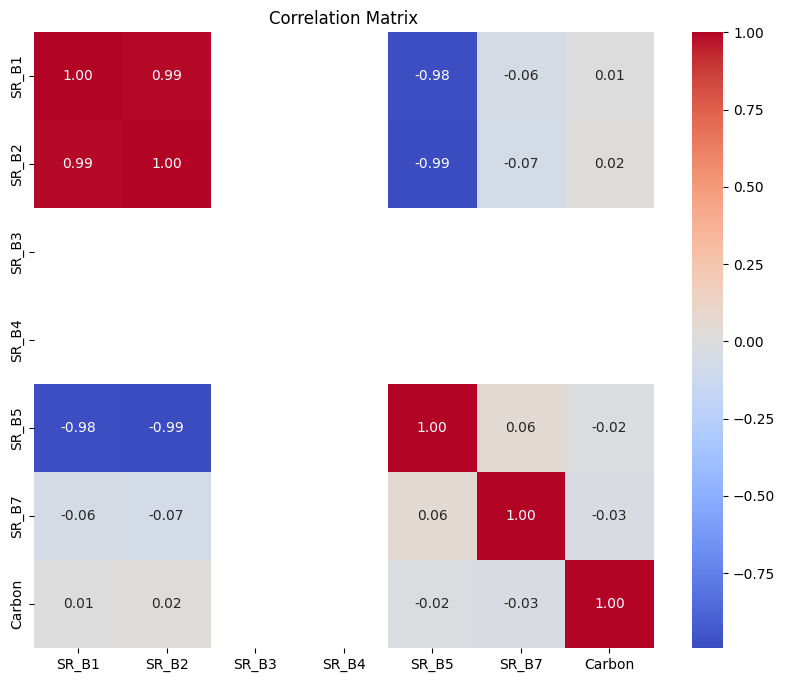

/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


Comparaison des modèles :

Linear Regression :
  Mean Squared Error: 7.22
  R² Score: -0.15
----------------------------------------
Random Forest :
  Mean Squared Error: 6.29
  R² Score: -0.00
----------------------------------------
GradientBoostingRegressor :
  Mean Squared Error: 6.29
  R² Score: -0.00
----------------------------------------
ExtraTreesRegressor :
  Mean Squared Error: 6.29
  R² Score: -0.00
----------------------------------------
BaggingRegressor :
  Mean Squared Error: 6.29
  R² Score: -0.00
----------------------------------------
VotingRegressor :
  Mean Squared Error: 6.29
  R² Score: -0.00
----------------------------------------
StackingRegressor :
  Mean Squared Error: 6.29
  R² Score: -0.00
----------------------------------------
HistGradientBoostingRegressor :
  Mean Squared Error: 6.26
  R² Score: 0.00
----------------------------------------


/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [ ]:
landsat_ird_data_7.rename(columns={"ProfileID":"Profile_id"}, inplace=True)
top_layers = data[data['Profondeur']==10]
data7 = pd.merge(top_layers[['Profile_id','Carbon']], landsat_ird_data_7, on='Profile_id', how='left')

corr_matrix = data7[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','Carbon']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
df_train_7 = data7.dropna(subset=['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','Carbon'])
X_train_7 = df_train_7[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']]
Y_train_7 = df_train_7['Carbon']
# Calculer les prédictions sur l'ensemble d'entraînement et l'ensemble de test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble d'entraînement et l'ensemble de test
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)

print("Root Mean Squared Error (MSE) on training set:", np.sqrt(mse_train))
print("Root Mean Squared Error (MSE) on test set:", np.sqrt(mse_test))

# Calculer le coefficient de détermination (R²)
train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)
print("Coefficient de détermination (R²) ON Train:", train_r2)
print("Coefficient de détermination (R²) ON Test:", test_r2)

In [ ]:
landsat_ird_data_8.rename(columns={"ProfileID":"Profile_id"}, inplace=True)

data8 = pd.merge(data[['Profile_id','Carbon','Profondeur','geometry']], landsat_ird_data_8, on='Profile_id', how='left')

data_10 = data8[data8['Profondeur']==10.0].copy()
data_30 = data8[data8['Profondeur']==30.0].copy()
data_10.rename(columns={"Carbon":"Carbon_10"}, inplace=True)
data_30.rename(columns={"Carbon":"Carbon_30"}, inplace=True)

data_all = pd.merge(data_10[['Profile_id','geometry','Carbon_10','SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']], data_30[['Profile_id','geometry','Carbon_30']], on='geometry', how='left', suffixes=('_10', '_30'))

data_all.dropna(inplace=True, axis=0, how='any')
data_all.reset_index(drop=True, inplace=True)
data_all



,Profile_id_10,geometry,Carbon_10,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,Profile_id_30,Carbon_30
0,1550,POINT (337391.020695 1603426.161072),4.18,10281.961074,11198.145602,13724.527716,16489.589061,21258.937669,24251.470067,1551.0,4.13
1,1552,POINT (336914.113937 1603584.630185),5.26,10672.028063,11578.249060,14277.679780,17318.255826,22163.435981,25201.526434,1553.0,9.16
2,1560,POINT (334835.800902 1603041.881657),3.90,10744.726220,11642.886397,14362.348201,17292.200345,21967.018975,25894.934943,1561.0,3.52
3,1562,POINT (334764.039365 1603021.782336),4.32,10718.262853,11625.778730,14303.752268,17153.964970,21746.323841,25791.566028,1563.0,6.16
4,1564,POINT (334889.357842 1603041.218633),10.02,10462.321799,11347.664607,13876.403856,16648.645576,21663.434256,24214.669797,1565.0,13.79
...,...,...,...,...,...,...,...,...,...,...,...
1719,2636,POINT (338115.8843 1612995.535),4.97,10401.731148,11272.221784,13794.013800,16589.124199,21131.325776,25529.668063,2637.0,9.87
1720,2638,POINT (338193.2305 1613108.469),7.83,10211.119271,11096.374076,13469.871365,15935.377526,20443.285855,24959.602267,2639.0,10.76
1721,2640,POINT (338225.6696 1613195.766),4.11,10041.035211,10884.422032,13134.099095,15488.040241,20033.331992,24355.779427,2641.0,8.24
1722,2642,POINT (338432.5458 1612860.281),4.88,10197.675789,11106.454882,13474.060158,15915.801282,20443.564596,24759.521450,2643.0,7.56


In [223]:
# Split train/test
def train( X_, Y_):
    
    X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2, random_state=42)
    # Modèles
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
  
    
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
  
   
    "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "BaggingRegressor": BaggingRegressor(n_estimators=100, random_state=42),
    
    # "AdaBoostRegressor": AdaBoostRegressor(n_estimators=100, random_state=42),
    "VotingRegressor": VotingRegressor(estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
        ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
        ('br', BaggingRegressor(n_estimators=100, random_state=42)),
        
    ]),
    "StackingRegressor": StackingRegressor(estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
        ('et', ExtraTreesRegressor(n_estimators=100, random_state=42)),
        ('br', BaggingRegressor(n_estimators=100, random_state=42)),
      
        
    ]),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor( random_state=42)

    }


    results = {}



    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'MSE': mse, 'R2': r2, 'Model': model, 'Predictions': y_pred}
        
    # Affichage des résultats
    print("Comparaison des modèles :\n")
    for name, metrics in results.items():
        print(f"{name} :")
        print(f"  Mean Squared Error: {metrics['MSE']:.2f}")
        print(f"  R² Score: {metrics['R2']:.2f}")
        print("-" * 40)


In [4]:
def replace_outliers_with_quantile(df, column, lower_quantile=0.05, upper_quantile=0.95):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_value = df[column].quantile(lower_quantile)
    upper_value = df[column].quantile(upper_quantile)

    df[column] = np.where(df[column] < lower_bound, lower_value, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_value, df[column])

    # # Filtrer les valeurs aberrantes
    # filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


# final_dataset = replace_outliers_with_quantile(final_dataset, 'Carbon')

In [101]:
Y

,Carbon_10
0,4.18
1,5.26
2,3.90
3,4.32
4,10.02
...,...
1719,4.97
1720,7.83
1721,4.11
1722,4.88


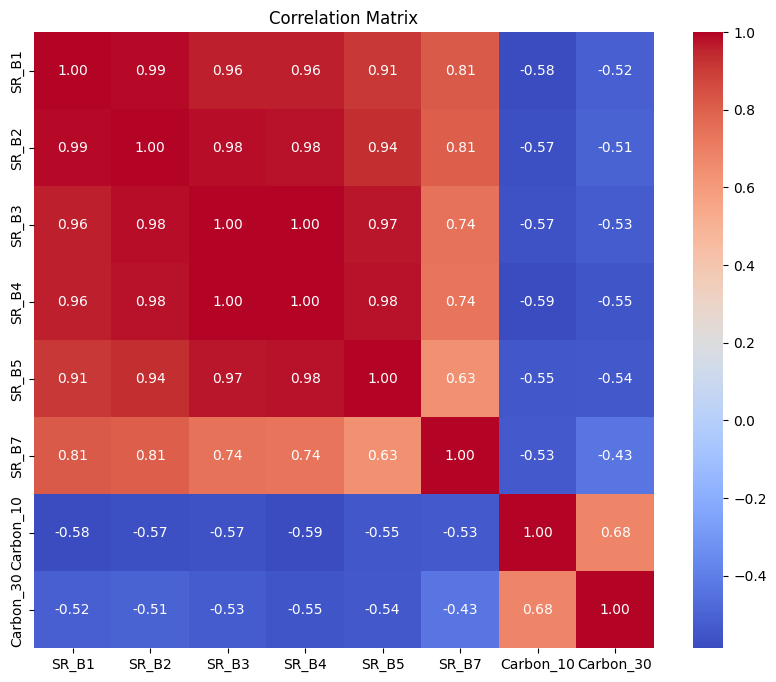

/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/

Comparaison des modèles :

Linear Regression :
  Mean Squared Error: 2.14
  R² Score: 0.44
----------------------------------------
Random Forest :
  Mean Squared Error: 2.14
  R² Score: 0.44
----------------------------------------
GradientBoostingRegressor :
  Mean Squared Error: 2.16
  R² Score: 0.44
----------------------------------------
ExtraTreesRegressor :
  Mean Squared Error: 2.07
  R² Score: 0.46
----------------------------------------
BaggingRegressor :
  Mean Squared Error: 2.15
  R² Score: 0.44
----------------------------------------
VotingRegressor :
  Mean Squared Error: 2.08
  R² Score: 0.46
----------------------------------------
StackingRegressor :
  Mean Squared Error: 2.07
  R² Score: 0.46
----------------------------------------
HistGradientBoostingRegressor :
  Mean Squared Error: 2.27
  R² Score: 0.41
----------------------------------------


In [ ]:

corr_matrix = data8[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','Carbon_10','Carbon_30']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
df_train_8 = data8.dropna(subset=['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7','Carbon_10','Carbon_30'])

df_train_8 = replace_outliers_with_quantile(df_train_8, 'Carbon_10',)

df_train_8 = replace_outliers_with_quantile(df_train_8, 'Carbon_30',)

Y_train_8 = df_train_8[['Carbon_10', ]]
X_train_8 = df_train_8.drop(columns=['Profile_id_10', 'Profile_id_30', 'Carbon_10', 'Carbon_30', 'geometry', ])


X = X_train_8[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']]
Y = Y_train_8
train(X, Y)

In [107]:
Y = df_train_8[['Carbon_30', ]]
X= df_train_8[['Carbon_10']]
train(X, Y)




/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


Comparaison des modèles :

Linear Regression :
  Mean Squared Error: 4.48
  R² Score: 0.55
----------------------------------------
Random Forest :
  Mean Squared Error: 5.36
  R² Score: 0.46
----------------------------------------
GradientBoostingRegressor :
  Mean Squared Error: 4.60
  R² Score: 0.53
----------------------------------------
ExtraTreesRegressor :
  Mean Squared Error: 5.96
  R² Score: 0.40
----------------------------------------
BaggingRegressor :
  Mean Squared Error: 5.36
  R² Score: 0.46
----------------------------------------
VotingRegressor :
  Mean Squared Error: 5.10
  R² Score: 0.48
----------------------------------------
StackingRegressor :
  Mean Squared Error: 4.70
  R² Score: 0.52
----------------------------------------
HistGradientBoostingRegressor :
  Mean Squared Error: 4.69
  R² Score: 0.52
----------------------------------------


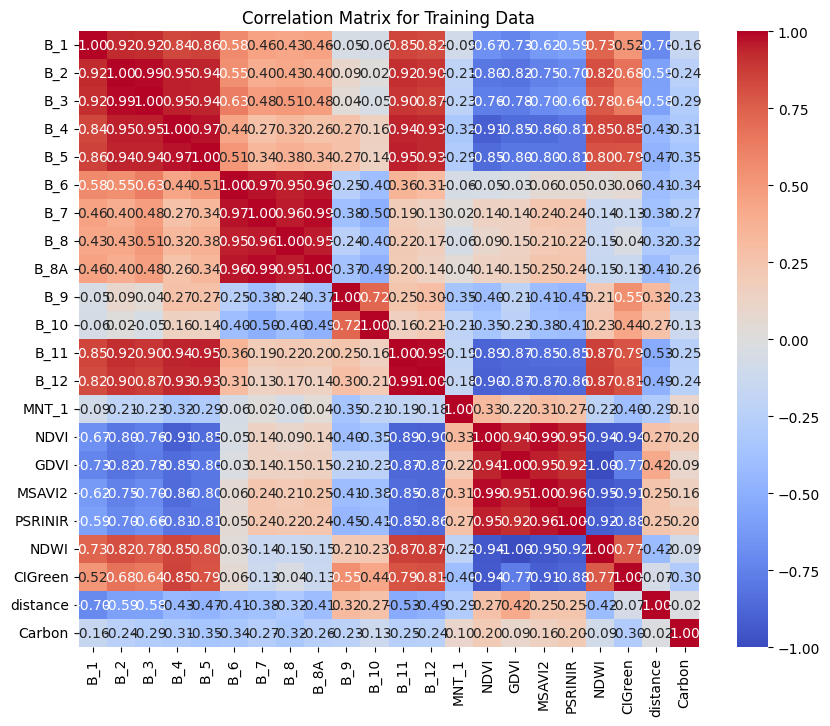

In [40]:
df_train = data.copy()
df_train = df_train[df_train['Profondeur']==10].copy()
df_train_corr = df_train[['B_1','B_2','B_3','B_4','B_5','B_6','B_7','B_8','B_8A','B_9','B_10','B_11','B_12','MNT_1','NDVI','GDVI','MSAVI2','PSRINIR','NDWI','CIGreen','distance','Carbon']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_train_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Training Data')
plt.show()

# df[['SumTxtr', 'CecSoil', 'PHH2O', 'ExBases', 'ExMg', 'Bsat', 'ExCa', 'ExK', 'OrgC', 'CN', 'TotalN']]

In [43]:
""" notin = [ i for i in ['SumTxtr', 'CecSoil', 'PHH2O', 'ExBases', 'ExMg', 'Bsat', 'ExCa', 'ExK', 'OrgC', 'CN', 'TotalN']  if i not in df.columns.tolist()]
# df_train = df_train[['SumTxtr', 'CecSoil', 'PHH2O', 'ExBases', 'ExMg', 'Bsat', 'ExCa', 'ExK', 'CN', 'TotalN', 'OrgC','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']]
df_train = df_train[[  'PHH2O',  'OrgC', 'B4', 'B5', 'B6', 'B7', ]]
NAN = -9999.0

# df = df[['ExK', 'Sand', 'Bsat2', 'Silt', 'ExCa', 'ExMg', 'BD_rule', 'CecSoil', 'PHH2O', 'Bsat', 'Clay', 'CaSO4', 'CaCO3', 'SumTxtr', 'ExBases','CN', 'TotalN','OrgC']]
df_train = df_train.replace(NAN, pd.NA)
df_train.dropna(inplace=True, axis=0, how='any')

# suppression les
for col in df_train.columns:
    if df_train[col].nunique() == 1:
        print(f"Suppression de la colonne {col} car toutes les valeurs sont identiques.")
        df_train.drop(col, axis=1, inplace=True) """

df_train = df_train[df_train['Profondeur']==10].copy()

df_train = df_train[['Carbon','Epaisseur','Profondeur','B_1','B_2','B_3','B_4','B_5','B_6','B_7','B_8','B_8A','B_9','B_10','B_11','B_12','MNT_1','NDVI','GDVI','MSAVI2','PSRINIR','NDWI','CIGreen','distance']]
df_train = replace_outliers_with_quantile(df_train, 'Carbon',)
Y = df_train['Carbon']
x_base = df_train.drop(columns=['Carbon', ]).copy()
x_base


,Epaisseur,Profondeur,B_1,B_2,B_3,B_4,B_5,B_6,B_7,B_8,...,B_11,B_12,MNT_1,NDVI,GDVI,MSAVI2,PSRINIR,NDWI,CIGreen,distance
0,10.0,10.0,0.17855,0.17550,0.19990,0.26885,0.27325,0.30435,0.34395,0.32845,...,0.51945,0.41065,12.962011,0.099782,0.243305,0.075370,1.202013,-0.243305,0.147093,42.156743
2,10.0,10.0,0.18155,0.17585,0.20025,0.27165,0.28350,0.31295,0.35765,0.33275,...,0.53790,0.42455,15.547010,0.101092,0.248593,0.076924,1.173721,-0.248593,0.151303,41.678423
10,10.0,10.0,0.18640,0.18565,0.21390,0.28820,0.29720,0.32845,0.37080,0.34655,...,0.58240,0.47530,13.255346,0.091926,0.236685,0.071988,1.166050,-0.236685,0.147978,39.607726
12,10.0,10.0,0.18785,0.18730,0.21650,0.29090,0.29800,0.33390,0.37560,0.34885,...,0.58230,0.47695,13.347013,0.090582,0.234103,0.071260,1.170638,-0.234103,0.146630,39.536405
14,10.0,10.0,0.18050,0.17510,0.20100,0.26685,0.27415,0.30685,0.35055,0.32820,...,0.54105,0.40790,12.797010,0.103101,0.240363,0.077723,1.197155,-0.240363,0.140750,39.661288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,10.0,10.0,0.16520,0.14060,0.15310,0.17400,0.20230,0.28060,0.32860,0.30370,...,0.43330,0.33000,21.655344,0.271509,0.329685,0.181982,1.501236,-0.329685,0.063895,43.838430
3618,10.0,10.0,0.16690,0.14990,0.16170,0.19570,0.23720,0.31350,0.36040,0.32470,...,0.43140,0.31500,20.566107,0.247886,0.335115,0.174985,1.368887,-0.335115,0.095132,43.937685
3620,10.0,10.0,0.16600,0.16980,0.19530,0.25750,0.25210,0.32880,0.37690,0.35920,...,0.44340,0.32470,18.997011,0.164910,0.295582,0.127883,1.424831,-0.295582,0.137367,43.987817
3622,10.0,10.0,0.16560,0.15580,0.17480,0.20700,0.21590,0.27350,0.31270,0.30760,...,0.40540,0.29490,21.105345,0.195492,0.275290,0.136021,1.424734,-0.275290,0.084337,44.120495


In [45]:

train(x_base, Y)

/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-p

Comparaison des modèles :

Linear Regression :
  Mean Squared Error: 2.49
  R² Score: 0.32
----------------------------------------
Random Forest :
  Mean Squared Error: 2.01
  R² Score: 0.46
----------------------------------------
GradientBoostingRegressor :
  Mean Squared Error: 2.05
  R² Score: 0.45
----------------------------------------
ExtraTreesRegressor :
  Mean Squared Error: 2.06
  R² Score: 0.44
----------------------------------------
BaggingRegressor :
  Mean Squared Error: 1.99
  R² Score: 0.46
----------------------------------------
VotingRegressor :
  Mean Squared Error: 1.98
  R² Score: 0.47
----------------------------------------
StackingRegressor :
  Mean Squared Error: 1.98
  R² Score: 0.46
----------------------------------------
HistGradientBoostingRegressor :
  Mean Squared Error: 2.23
  R² Score: 0.40
----------------------------------------



# df = df[['SumTxtr', 'CecSoil', 'PHH2O', 'ExBases',  'OrgC', 'CN', 'TotalN']]

In [ ]:
X = x_base[['B_1','B_2','B_3','B_4','B_5','B_6','B_7','B_8','B_8A','B_9','B_10','B_11','B_12','MNT_1','NDVI','GDVI','MSAVI2','PSRINIR','NDWI','CIGreen','distance']]

# train(X, Y)

/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-p

Comparaison des modèles :

Linear Regression :
  Mean Squared Error: 2.49
  R² Score: 0.32
----------------------------------------
Random Forest :
  Mean Squared Error: 2.15
  R² Score: 0.42
----------------------------------------
GradientBoostingRegressor :
  Mean Squared Error: 2.20
  R² Score: 0.40
----------------------------------------
ExtraTreesRegressor :
  Mean Squared Error: 2.13
  R² Score: 0.42
----------------------------------------
BaggingRegressor :
  Mean Squared Error: 2.15
  R² Score: 0.42
----------------------------------------
VotingRegressor :
  Mean Squared Error: 2.11
  R² Score: 0.43
----------------------------------------
StackingRegressor :
  Mean Squared Error: 2.10
  R² Score: 0.43
----------------------------------------
HistGradientBoostingRegressor :
  Mean Squared Error: 2.32
  R² Score: 0.37
----------------------------------------


In [ ]:
# install xgboost
# !pip install xgboost lightgbm
# !brew install libomp


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:20fa657858e44a4b39171d6e4111f8a9716eb62a78ebbd1491d94f90bb7b830a
######################################################################### 100.0%            72.2%
==> Pouring portable-ruby-3.4.5.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
ayatana-ido: Ayatana Indicator Display Objects
cargo-component: Create WebAssembly components based on the component model proposal
ccusage: CLI tool for analyzing Claude Code usage from local JSONL files
dagu: Lightweight and powerful workflow engine
genai-toolbox: MCP Toolbox for Databases

In [ ]:
print(x_base[['B_1','B_2','B_3','B_4','B_5','B_6','B_7','B_8','B_8A','B_9','B_10','B_11','B_12','MNT_1','NDVI','GDVI','MSAVI2','PSRINIR','NDWI','CIGreen','distance']].describe())

               B_1          B_2          B_3          B_4          B_5  \
count  1750.000000  1750.000000  1750.000000  1750.000000  1750.000000   
mean      0.165026     0.154853     0.169961     0.207853     0.227857   
std       0.010889     0.016493     0.023591     0.046869     0.037426   
min       0.143800     0.123000     0.119100     0.112400     0.143000   
25%       0.157100     0.142200     0.152112     0.172400     0.199825   
50%       0.161400     0.150000     0.163775     0.200750     0.221500   
75%       0.175237     0.168738     0.186338     0.242662     0.252587   
max       0.191700     0.195100     0.233100     0.321100     0.330550   

               B_6          B_7          B_8         B_8A          B_9  ...  \
count  1750.000000  1750.000000  1750.000000  1750.000000  1750.000000  ...   
mean      0.291468     0.335767     0.317012     0.374686     0.065362  ...   
std       0.028240     0.033051     0.027533     0.032733     0.011414  ...   
min       0.20410

In [263]:
# Install libomp if not already installed (for Mac OSX XGBoost OpenMP support)
# You may need to restart the kernel after running this cell


# Importer les bibliothèques nécessaires
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Définir les modèles individuels
xgb_model = XGBRegressor( n_estimators = 100, max_depth = 5, random_state=42)

lgbmr = lgb.LGBMRegressor(n_estimators = 300, max_depth = 5, num_leaves = 50, force_col_wise=True, verbosity=-1)
gbr = GradientBoostingRegressor(n_estimators = 200, max_depth =  5)
hgb = HistGradientBoostingRegressor(max_iter=300, max_depth=5, learning_rate = 0.1, max_bins = 255, max_leaf_nodes = 31, min_samples_leaf = 20, random_state=42)
rf = RandomForestRegressor(n_estimators = 1000, max_depth = 20, max_features = 'sqrt', random_state=42)

# Créer les pipelines pour chaque modèle
xgb_pipeline = make_pipeline(StandardScaler(), xgb_model)
lgbmr_pipeline = make_pipeline(StandardScaler(), lgbmr)
gbr_pipeline = make_pipeline(StandardScaler(), gbr)
hgb_pipeline = make_pipeline(StandardScaler(), hgb)
rf_pipeline = make_pipeline(StandardScaler(), rf)


# Créer l'ensemble de modèles
estimators = [
    ('lgbmr', lgbmr_pipeline),
    ('gbr', gbr_pipeline),
    ('XGBRegressor', xgb_pipeline),
    ('HistGradientBoostingRegressor', hgb_pipeline),
    ('RandomForestRegressor', rf_pipeline)
]


final_estimator = RidgeCV()
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator, cv = 5)


# Y_train_8 = df_train_8['Carbon']
# X_train_8 = df_train_8.drop(columns=['Profile_id', 'Carbon'])

# data8
# train(X_train_8[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7',]], Y_train_8)
X_train_7, Y_train_7
Y = Y_train_7.fillna(Y_train_7.mean())
# X_train_8.fillna(X_train_8.mean(), inplace=True)
X = X_train_7[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7',]]

X_train , X_test , Y_train , Y_test = train_test_split( X , Y , test_size=0.2 , random_state=42 )
history = model.fit(X_train,Y_train)

In [264]:
# Calculer les prédictions sur l'ensemble d'entraînement et l'ensemble de test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble d'entraînement et l'ensemble de test
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)

print("Root Mean Squared Error (MSE) on training set:", np.sqrt(mse_train))
print("Root Mean Squared Error (MSE) on test set:", np.sqrt(mse_test))

# Calculer le coefficient de détermination (R²)
train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)
print("Coefficient de détermination (R²) ON Train:", train_r2)
print("Coefficient de détermination (R²) ON Test:", test_r2)

Root Mean Squared Error (MSE) on training set: 0.6202849873952674
Root Mean Squared Error (MSE) on test set: 1.1878183204490578
Coefficient de détermination (R²) ON Train: 0.8671070354994871
Coefficient de détermination (R²) ON Test: 0.4456152477099222


/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-p

In [ ]:
Root Mean Squared Error (MSE) on training set: 1.0172165763664527
Root Mean Squared Error (MSE) on test set: 1.4157238722540983
Coefficient de détermination (R²) ON Train: 0.7371796136466144
Coefficient de détermination (R²) ON Test: 0.5126152554729444

# 60
Root Mean Squared Error (MSE) on training set: 0.7521255754688899
Root Mean Squared Error (MSE) on test set: 1.240147841272058
Coefficient de détermination (R²) ON Train: 0.804610976344256
Coefficient de détermination (R²) ON Test: 0.39569225338702285

Root Mean Squared Error (MSE) on training set: 0.47819234667854704
Root Mean Squared Error (MSE) on test set: 1.449279173716218
Coefficient de détermination (R²) ON Train: 0.9433602990896505
Coefficient de détermination (R²) ON Test: 0.4312825776882224

Root Mean Squared Error (MSE) on training set: 0.4907931456025045
Root Mean Squared Error (MSE) on test set: 1.4414427197961803
Coefficient de détermination (R²) ON Train: 0.9403359559425271
Coefficient de détermination (R²) ON Test: 0.43741621830151767

Réduire le nombre d'estimateurs (500+ arbres × 5 modèles → très complexe)

Ajouter de la régularisation (alpha, lambda pour XGB/LGB)

Faire du feature selection automatique

Ajouter des features spatiaux (ex : cluster ID, coordonnées normalisées)

Appliquer un KFold ou CV en amont pour valider plus finement

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extraire le modèle entraîné (par exemple le LightGBM)
lgb_model_fitted = model.named_estimators_['lgbmr'].named_steps['lgbmregressor']

# Afficher les importances
importances = lgb_model_fitted.feature_importances_

Y = Y_train_8.fillna(Y_train_8.mean())
# X_train_8.fillna(X_train_8.mean(), inplace=True)
X = X_train_8[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7',]]

# Créer un DataFrame trié
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title("🎯 Importance des variables (LightGBM)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


AttributeError: 'LGBMRegressor' object has no attribute 'named_estimators_'

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
param_grid = {
    'lgbmregressor__num_leaves': [15, 31, 50],
    'lgbmregressor__max_depth': [3, 5, 7],
    'lgbmregressor__learning_rate': [0.01, 0.1, 0.2],
    'lgbmregressor__n_estimators': [100, 300]
}
feature_names = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']

# Pipeline
lgbmr_pipeline = make_pipeline(StandardScaler(), lgb.LGBMRegressor(force_col_wise=True, verbosity=-1))


model = lgb.LGBMRegressor(n_estimators=300)
model.fit(X, Y)

selector = SelectFromModel(model, threshold='median')
selector.fit(X, Y)

# ✅ Colonnes sélectionnées
X_selected = pd.DataFrame(selector.transform(X), columns=X.columns[selector.get_support()])

grid_search = GridSearchCV(lgbmr_pipeline, param_grid, cv=5, scoring='r2', verbose=0, n_jobs=-1)
grid_search.fit(X, Y)

print("📌 Best params:", grid_search.best_params_)
print("📈 Best R²:", grid_search.best_score_)


/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid featu

📌 Best params: {'lgbmregressor__learning_rate': 0.01, 'lgbmregressor__max_depth': 7, 'lgbmregressor__n_estimators': 300, 'lgbmregressor__num_leaves': 50}
📈 Best R²: 0.39387785181849366


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
# Définir les sous-modèles avec pipeline
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# ignore all warnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class PandasStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.columns = None

    def fit(self, X, y=None):
        self.columns = X.columns
        self.scaler.fit(X, y)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        return pd.DataFrame(X_scaled, columns=self.columns, index=X.index)


xgb_pipeline = make_pipeline(
    PandasStandardScaler(),
    XGBRegressor(random_state=42)
)

lgb_pipeline = make_pipeline(
    PandasStandardScaler(),
    lgb.LGBMRegressor(force_col_wise=True, verbosity=-1)
)

gbr_pipeline = make_pipeline(
    PandasStandardScaler(),
    GradientBoostingRegressor(random_state=42)
)

# Ensemble de modèles
estimators = [
    ('xgb', xgb_pipeline),
    ('lgb', lgb_pipeline),
    ('gbr', gbr_pipeline)
]

# Modèle principal : RidgeCV
final_estimator = RidgeCV()

# Stacking
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

# Grille des paramètres (accès via nom_pipeline__nom_estimateur__paramètre)
param_grid = {
    'xgb__xgbregressor__n_estimators': [100, 200],
    'xgb__xgbregressor__max_depth': [3, 5],
    'lgb__lgbmregressor__n_estimators': [100, 300],
    'lgb__lgbmregressor__num_leaves': [15, 31],
    'gbr__gradientboostingregressor__n_estimators': [100, 200],
    'gbr__gradientboostingregressor__max_depth': [3, 5]
}

# GridSearchCV sur le Stacking
grid_search = GridSearchCV(
    estimator=stack_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=0,
    n_jobs=-1
)


model = lgb.LGBMRegressor(n_estimators=300)
model.fit(X, Y)

selector = SelectFromModel(model, threshold='median')
selector.fit(X, Y)
feature_names = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']
# ✅ Colonnes sélectionnées
X_selected = X.loc[:, selector.get_support()]
print("✅ Colonnes sélectionnées :", X_selected.columns.tolist())
print("✅ Format : ", type(X_selected))
# Lancer l'entraînement
grid_search.fit(X_selected, Y)

# Résultats
print("\n✅ Best params found:")
print(grid_search.best_params_)
print("📈 Best R² score:", grid_search.best_score_)


✅ Colonnes sélectionnées : ['SR_B1', 'SR_B2', 'SR_B7']
✅ Format :  <class 'pandas.core.frame.DataFrame'>


/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/magayendiaye/projects/soc/env/lib/python3.13/site-p


✅ Best params found:
{'gbr__gradientboostingregressor__max_depth': 3, 'gbr__gradientboostingregressor__n_estimators': 100, 'lgb__lgbmregressor__n_estimators': 100, 'lgb__lgbmregressor__num_leaves': 15, 'xgb__xgbregressor__max_depth': 3, 'xgb__xgbregressor__n_estimators': 200}
📈 Best R² score: 0.35330916877212365
